Hamiltonian-Simulation Benchmark Program - Braket
... execution starting at Sep 19, 2024 05:26:38 UTC
************
Executing [1] circuits with num_qubits = 2
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 25, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 25, 0, 0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.002, 0.036, 0.036 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [1] circuits with num_qubits = 3
Average Circuit Algorithmic Depth, ξ (xi) for the 3 qubit group = 42, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 3 qubit group = 42, 0, 0
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.002, 0.028, 0.028 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 0.999, 0.999

************
Executing [1] circuits with num_qubits = 4
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 44, 0
Average 

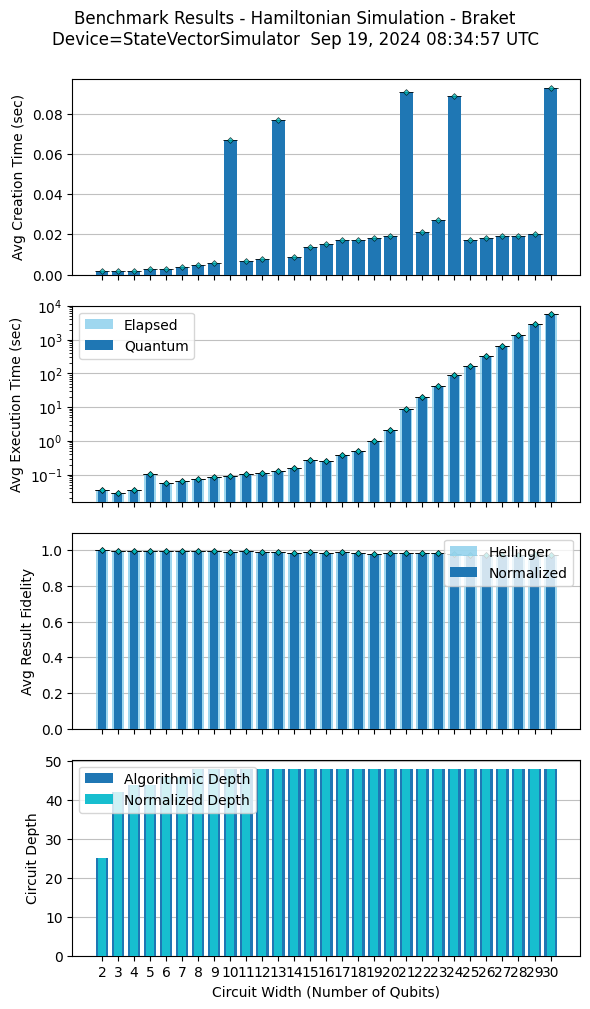

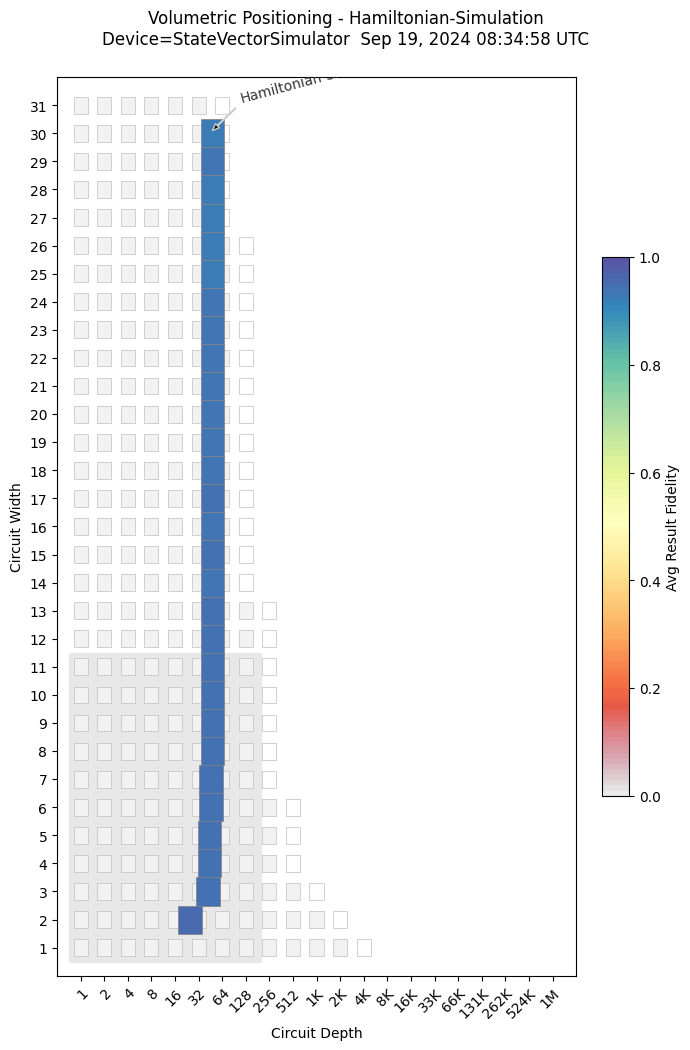

In [1]:
"""
Hamiltonian-Simulation Benchmark Program - Braket
"""

import json
import os
import sys
import time

import numpy as np

from braket.circuits import Circuit  # AWS imports: Import Braket SDK modules

sys.path[1:1] = [ "_common", "_common/braket" ]
sys.path[1:1] = [ "../../_common", "../../_common/braket" ]
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False
qcs = [None, None, None]    # saved subcircuits for printing (not used yet in braket)

# save main circuit to display
QC_ = None

# for validating the implementation of XXYYZZ operation
_use_XX_YY_ZZ_gates = False

# import precalculated data to compare against
filename = os.path.join(os.path.pardir, "_common", "precalculated_data.json")
with open(filename, 'r') as file:
    data = file.read()
precalculated_data = json.loads(data)

############### Circuit Definition

def HamiltonianSimulation(n_spins, K, t, w, h_x, h_z):
    '''
    Construct a Braket circuit for Hamiltonian Simulation
    :param n_spins:The number of spins to simulate
    :param K: The Trotterization order
    :param t: duration of simulation
    :return: return a braket circuit for this Hamiltonian
    '''
    
    # allocate circuit
    qc = Circuit()
    tau = t / K

    # start with initial state of 1010101...
    for k in range(0, n_spins, 2):
        qc.x(k)

    # loop over each trotter step, adding gates to the circuit defining the hamiltonian
    for k in range(K):
    
        # the Pauli spin vector product
        [qc.rx(i, 2 * tau * w * h_x[i]) for i in range(n_spins)]
        [qc.rz(i, 2 * tau * w * h_z[i]) for i in range(n_spins)]

        # Basic implementation of exp(i * t * (XX + YY + ZZ))
        if _use_XX_YY_ZZ_gates:

            # XX operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qcs[0] = qc_xx = xx_gate(qc, tau, [i, (i + 1) % n_spins])
                    #qc.append(qc_xx.to_instruction(), [i, (i + 1) % n_spins])

            # YY operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qcs[1] = qc_yy = yy_gate(qc, tau, [i, (i + 1) % n_spins])
                    #qc.append(qc_yy.to_instruction(), [i, (i + 1) % n_spins])

            # ZZ operation on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j%2, n_spins - 1, 2):
                    qcs[2] = qc_zz = zz_gate(qc, tau, [i, (i + 1) % n_spins])
                    #qc.append(qc_zz.to_instruction(), [i, (i + 1) % n_spins])

        # Use an optimal XXYYZZ combined operator
        # See equation 1 and Figure 6 in https://arxiv.org/pdf/quant-ph/0308006.pdf
        else:

            # optimized XX + YY + ZZ operator on each pair of qubits in linear chain
            for j in range(2):
                for i in range(j % 2, n_spins  - 1, 2):
                    qcs[0] = qc_xxyyzz = xxyyzz_opt_gate(qc, tau, [i, (i + 1) % n_spins])
                    #qc.append(qc_xxyyzz.to_instruction(), [i, (i + 1) % n_spins])

    # save smaller circuit example for display
    global QC_    
    if QC_ == None or n_spins <= 6:
        if n_spins < 9: QC_ = qc

    return qc

############### XX, YY, ZZ Gate Implementations

# Simple XX gate on q0 and q1 with angle 'tau'
def xx_gate(qc, tau, qr):
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cnot(qr[0], qr[1])
    qc.rz(qr[1], 3.1416*tau)
    qc.cnot(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    return qc

# Simple YY gate on q0 and q1 with angle 'tau'    
def yy_gate(qc, tau, qr):
    qc.s(qr[0])
    qc.s(qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.cnot(qr[0], qr[1])
    qc.rz(qr[1], 3.1416*tau)
    qc.cnot(qr[0], qr[1])
    qc.h(qr[0])
    qc.h(qr[1])
    qc.si(qr[0])
    qc.si(qr[1])
    return qc

# Simple ZZ gate on q0 and q1 with angle 'tau'
def zz_gate(qc, tau, qr):
    qc.cnot(qr[0], qr[1])
    qc.rz(qr[1], 3.1416*tau)
    qc.cnot(qr[0], qr[1])
    return qc

# Optimal combined XXYYZZ gate (with double coupling) on q0 and q1 with angle 'tau'
def xxyyzz_opt_gate(qc, tau, qr):
    alpha = tau; beta = tau; gamma = tau

    qc.rz(qr[1], 3.1416/2)
    qc.cnot(qr[1], qr[0])
    qc.rz(qr[0], 3.1416*gamma - 3.1416/2)
    qc.ry(qr[1], 3.1416/2 - 3.1416*alpha)
    qc.cnot(qr[0], qr[1])
    qc.ry(qr[1], 3.1416*beta - 3.1416/2)
    qc.cnot(qr[1], qr[0])
    qc.rz(qr[0], -3.1416/2)
    return qc


############### Result Data Analysis

# Analyze and print measured results
# Compute the quality of the result based on operator expectation for each state
def analyze_and_print_result(qc, result, num_qubits, type):

    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots

    # obtain counts from the result object
    counts_r = result.measurement_counts
    
    # obtain counts from the result object
    # for braket, need to reverse the key to match binary order
    # for braket, measures all qubits, so we have to remove data qubit measurement
    counts_r = result.measurement_counts
    counts = {}
    for measurement_r in counts_r.keys():
        measurement = measurement_r[::-1] # reverse order
        counts[measurement] = counts_r[measurement_r]  
    if verbose: print(f"For type {type} measured: {counts}")    
    
    # we have precalculated the correct distribution that a perfect quantum computer will return
    # it is stored in the json file we import at the top of the code
    correct_dist = precalculated_data[f"Qubits - {num_qubits}"]
    if verbose: print(f"Correct dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

################ Benchmark Loop

# Execute program with default parameters
def run(min_qubits=2, max_qubits=30, max_circuits=3, num_shots=1000,
        use_XX_YY_ZZ_gates = False,
        backend_id='simulator'):

    print("Hamiltonian-Simulation Benchmark Program - Braket")
    
    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # set the flag to use an XX YY ZZ shim if given
    global _use_XX_YY_ZZ_gates
    _use_XX_YY_ZZ_gates = use_XX_YY_ZZ_gates
    if _use_XX_YY_ZZ_gates:
        print("... using unoptimized XX YY ZZ gates")

    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler(qc, result, num_qubits, type):
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, expectation_a = analyze_and_print_result(qc, result, num_qubits, type)
        metrics.store_metric(num_qubits, type, 'fidelity', expectation_a)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):

        # determine number of circuits to execute for this group
        num_circuits = min(1, max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        # parameters of simulation
        #### CANNOT BE MODIFIED W/O ALSO MODIFYING PRECALCULATED DATA #########
        w = precalculated_data['w']  # strength of disorder
        k = precalculated_data['k']  # Trotter error.
               # A large Trotter order approximates the Hamiltonian evolution better.
               # But a large Trotter order also means the circuit is deeper.
               # For ideal or noise-less quantum circuits, k >> 1 gives perfect hamiltonian simulation.
        t = precalculated_data['t']  # time of simulation
        #######################################################################

        # loop over only 1 circuit
        for circuit_id in range(num_circuits):
        
            # create the circuit for given qubit size and simulation parameters, store time metric
            ts = time.time()
            h_x = precalculated_data['h_x'][:num_qubits] # precalculated random numbers between [-1, 1]
            h_z = precalculated_data['h_z'][:num_qubits]
            qc = HamiltonianSimulation(num_qubits, K=k, t=t, w=w, h_x= h_x, h_z=h_z)
            metrics.store_metric(num_qubits, circuit_id, 'create_time', time.time() - ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, circuit_id, shots=num_shots)

        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    # ex.execute_circuits()
    # metrics.aggregate_metrics_for_group(num_qubits)
    # metrics.report_metrics_for_group(num_qubits)
    
    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    '''
    if _use_XX_YY_ZZ_gates:
        print("\n********\nXX, YY, ZZ =")
        print(qcs[0]); print(qcs[1]); print(qcs[2])
    else:
        print("\n********\nXXYYZZ =")
        print(qcs[0])
    '''   
    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Hamiltonian Simulation - Braket")


# if main, execute method
if __name__ == '__main__': run()
